<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_5_Computer_says_no_Akimkin_Timofey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif


# import warnings
# warnings.filterwarnings('ignore')

# import sys
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# sys.path.clear
# sys.path.append('/content/gdrive/MyDrive/SkillFactory')

In [75]:
path = 'https://raw.githubusercontent.com/akitim/datasets/main/computer_says_no.csv'
data = pd.read_csv(path, encoding = 'ISO-8859-1', low_memory = False)
data.sample(1)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
2432,54756,SCH,F,63,N,N,0,0,2,1,2,10000,N,0


In [76]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


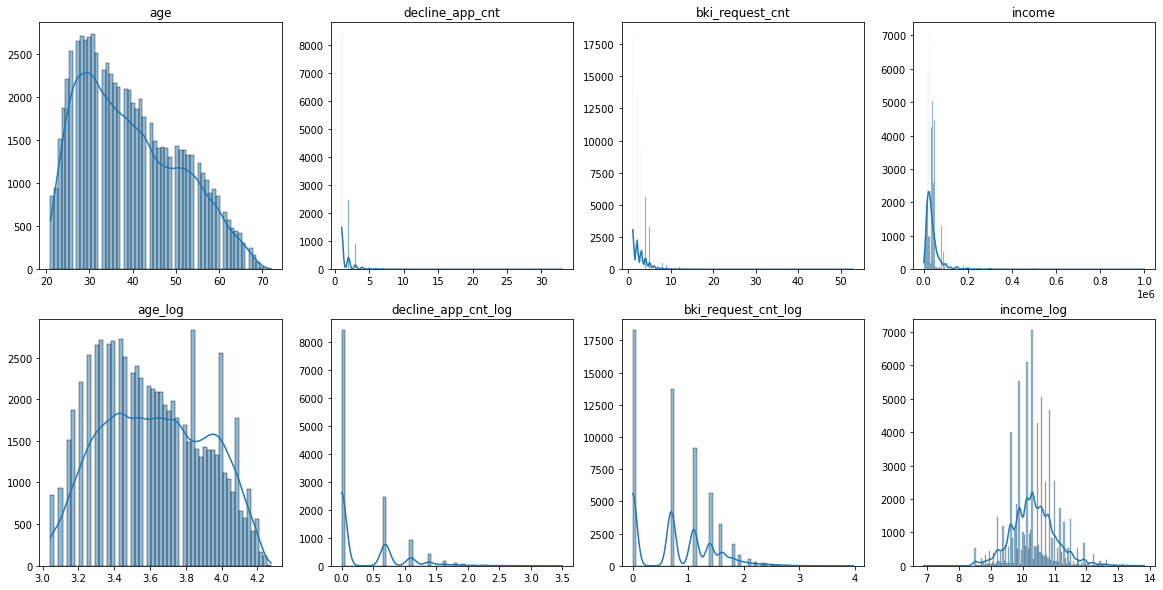

In [77]:
#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address']

#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

fig, ax = plt.subplots(2, 4, sharey=False, figsize=(20,10))
for cat in enumerate(num_cols):
    ax_curr = ax[0, cat[0]] #(cat[0] // 2 + 1, 2*cat[0] % 4 + 1, 2*cat[0] % 4) - горизонтальное размещение
    sns.histplot(data[cat[1]][data[cat[1]] > 0].dropna(), kde=True, ax=ax_curr)
    ax_curr.set_title(cat[1])
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')

    ax_curr = ax[1, cat[0]] #(cat[0] // 2 + 1, 2*cat[0] % 4 + 1, 2*cat[0] % 4) - горизонтальное размещение
    sns.histplot(data[cat[1]][data[cat[1]] > 0].apply(np.log).dropna(), kde=True, ax=ax_curr)
    ax_curr.set_title(cat[1] + '_log')
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')

SCH    38860
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

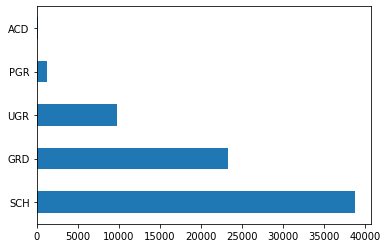

In [78]:
data.education.value_counts().plot.barh();
data.education.value_counts()

In [79]:
# np.random.RandomState = 49

edu_species = data.education.dropna().unique()
edu_species_num = edu_species.shape[0]
weights = data.education.value_counts() / data.education.count()

data.education = data.education.apply(
    lambda x: np.random.choice(edu_species, 1, p = weights)[0] if pd.isna(x) else x
)   

In [80]:
data.sample(1)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
70308,1284,SCH,F,37,N,N,1,0,2,1,2,15000,N,0


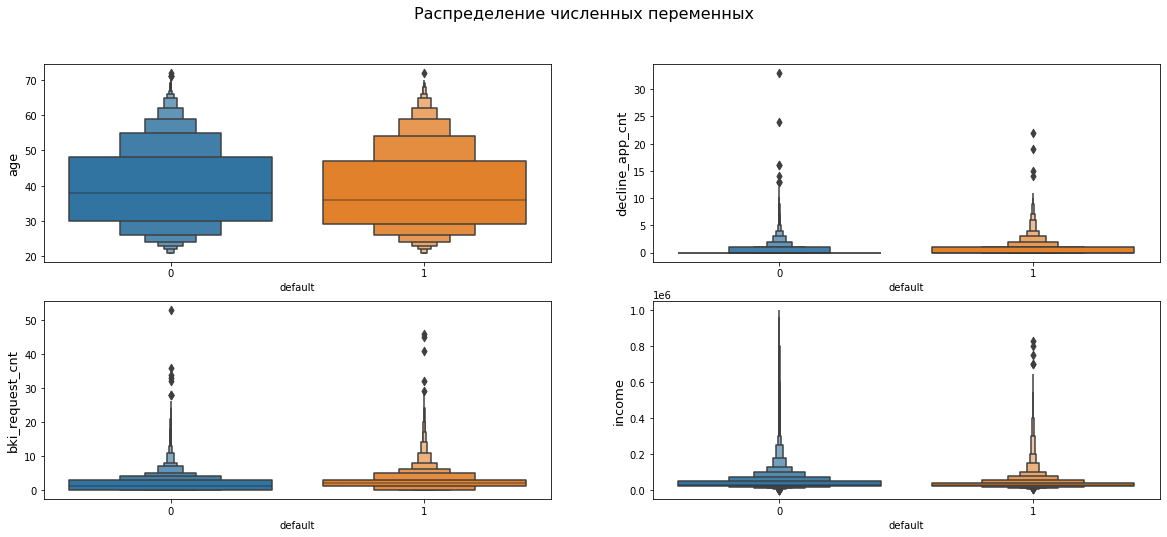

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
for cat in enumerate(num_cols):
    ax_c = ax[cat[0] // 2, cat[0] % 2]
    sns.boxenplot(x='default', y=cat[1], data=data[num_cols+['default']], ax=ax_c)
    ax_c.set_ylabel(cat[1], fontsize=13)
# ax2 = sns.boxenplot(x='', y='', data=data[])
fig.suptitle('Распределение численных переменных', fontsize=16);

In [82]:
decline_grouped = data.groupby(by='default')['decline_app_cnt']

df = pd.concat([ decline_grouped.mean(), 
                decline_grouped.median(), 
                pd.Series([data[data.default == 0]['decline_app_cnt'].mode().values, 
                           data[data.default == 1]['decline_app_cnt'].mode().values
                ]) ], axis=1
)
df.columns = ['mean', 'median', 'mode']
df.index = ['Недефолтники:', 'Дефолтники:']
df

,mean,median,mode
Недефолтники:,0.240877,0,[0]
Дефолтники:,0.515472,0,[0]


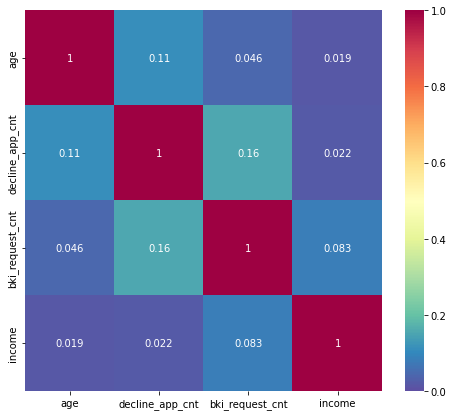

In [83]:
plt.figure(figsize=(8, 7))
ax = sns.heatmap(data[num_cols].corr().abs(), annot=True, vmin=0, vmax=1, cmap='Spectral_r');

###ANOVA анализ

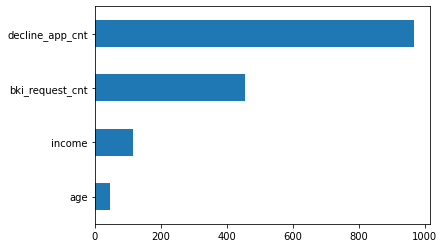

In [84]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Признак decline_app_cnt - самый значимый.

#Label encoding

In [85]:
from sklearn.preprocessing import LabelEncoder
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

data.education = label_encoder.fit_transform(data.education)    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,3,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,3,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,3,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,3,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,1,1,48,0,0,0,1,1,2,3,30000,1,0


#ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

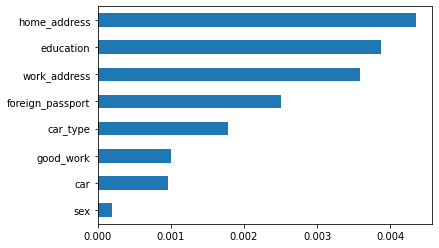

In [86]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

#Предобработка переменных

In [87]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# One-Hot Encoding категориальных переменных
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat.shape

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [88]:
# Объединяем
X = np.hstack([X_num, data[bin_cols].values, X_cat])
y = data['default'].values

In [98]:
# Обучаем модель
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(max_iter=1000)
lgr.fit(X, y)
y_proba = lgr.predict_proba(X)[:, 0]
y_pred = lgr.predict(X)

#Метрики модели

In [94]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

confusion_matrix(y, y_pred)

array([[64317,   110],
       [ 9298,    74]])

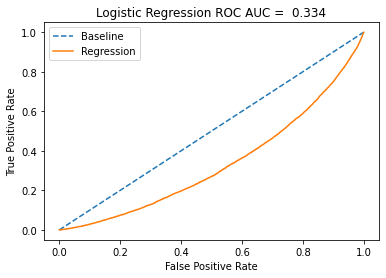

In [99]:
roc_auc = roc_auc_score(y, y_proba)

fpr, tpr, thresholds = roc_curve(y, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title(f'Logistic Regression ROC AUC =  {roc_auc:0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'upper left')
plt.show()

In [21]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     64427
           1       0.40      0.01      0.02      9372

    accuracy                           0.87     73799
   macro avg       0.64      0.50      0.47     73799
weighted avg       0.81      0.87      0.82     73799



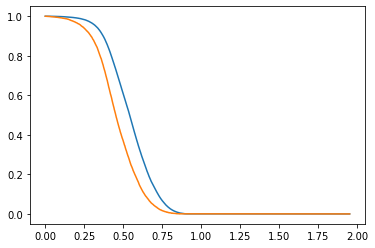

In [105]:
plt.plot(thresholds, fpr);
plt.plot(thresholds, tpr);

#Оптимизация гиперпараметров

In [34]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3
C = np.logspace(0, 4, 5)

param_grid = [
    {'C': C,
     'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'C': C,
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':[None, 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'C': C,
     'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X, y)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        # print('\t%s: %r' % (param_name, best_parameters[param_name]))
        print(f'\t{param_name}: {best_parameters[param_name]}')

	C: 1.0
	class_weight: balanced
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: ovr
	n_jobs: None
	penalty: none
	random_state: None
	solver: saga
	tol: 0.001
	verbose: 0
	warm_start: False


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [23]:
# for param_name in sorted(best_parameters.keys()):
#         # print('\t%s: %r' % (param_name, best_parameters[param_name]))
#         print(f'\t{param_name}: {best_parameters[param_name]}')

###Применяем гиперпараметры, найденные при оптимизации

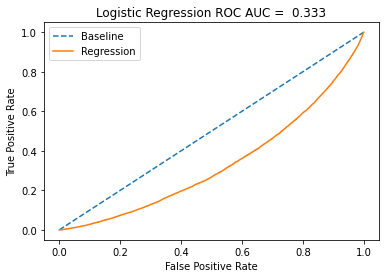

In [102]:
y_proba_opt = model.predict_proba(X)[:, 0]

roc_auc = roc_auc_score(y, y_proba_opt)

fpr, tpr, thresholds = roc_curve(y, y_proba_opt)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title(f'Logistic Regression ROC AUC =  {roc_auc:0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'upper left')
plt.show()